In [1]:
import numpy as np
import pandas as pd

In [2]:
formation_tops = pd.read_csv('test2_formation_tops.txt',delimiter='\t')
formation_tops['Top'] = formation_tops['Top'].astype('float64',copy=True)
formation_tops['Bottom'] = formation_tops['Bottom'].astype('float64',copy=True)
print(formation_tops)

  WellName Horizon    Top  Bottom
0       A1      PK  300.0   400.0
1       A2      KS  220.0   280.0
2       A3      KS  250.0   285.0
3       A4      KS  250.0   285.0
4       A5      KS  250.0   285.0


In [3]:
flow_units = pd.read_csv('test2_flow_unit_tops.txt',delimiter='\t')
flow_units['Top'] = flow_units['Top'].astype('float64',copy=True)
flow_units['Bottom'] = flow_units['Bottom'].astype('float64',copy=True)
print(flow_units)

   WellName FlowUnit    Top  Bottom
0        A1    PK-up  300.0   350.0
1        A1    PK-lw  355.0   395.0
2        A2      KS1  225.0   235.0
3        A2      KS2  240.0   255.0
4        A2      KS3  265.0   270.0
5        A2      KS4  272.0   273.0
6        A3      KS1  255.0   257.0
7        A3      KS2  262.0   267.0
8        A4      KS3  245.0   248.0
9        A4      KS4  262.0   272.0
10       A5      KS1  240.0   255.0
11       A5      KS2  265.0   270.0
12       A5      KS3  272.0   273.0
13       A5      KS4  255.0   257.0


In [4]:
perfs = pd.read_csv('test2_perforations.txt',delimiter='\t')
perfs['Date'] = perfs['Date'].astype('datetime64[s]',copy=True)
perfs['Top'] = perfs['Top'].astype('float64',copy=True)
perfs['Bottom'] = perfs['Bottom'].astype('float64',copy=True)
print(perfs)

   WellName       Date Horizon    Top  Bottom
0        A1 2022-01-10      PK  305.0   308.0
1        A1 2022-02-20      PK  295.0   306.0
2        A1 2022-03-25      PK  307.0   320.0
3        A1 2022-04-01      PK  340.0   360.0
4        A1 2022-05-06      PK  338.0   366.0
5        A1 2022-10-07      PK  366.0   374.0
6        A1 2022-12-11      PK  341.0   370.0
7        A1 2023-01-11      PK  370.0   405.0
8        A2 2022-01-03      KS  210.0   230.0
9        A2 2022-01-25      KS  250.0   295.0
10       A2 2022-02-16      KS  295.0   303.0
11       A2 2022-03-10      KS  218.0   222.0
12       A2 2022-04-01      KS  256.0   258.0
13       A2 2022-04-23      KS  220.0   250.0


In [5]:
rates = pd.read_csv('test2_production_horizon_based.txt',delimiter='\t')
rates['Date'] = rates['Date'].astype('datetime64[s]',copy=True)
rates['OilRate'] = rates['OilRate'].astype('float64',copy=True)
print(rates)

   WellName       Date Horizon  OilRate
0        A1 2022-01-01      PK     15.0
1        A1 2022-02-01      PK     14.3
2        A1 2022-03-01      PK     13.5
3        A1 2022-04-01      PK     12.9
4        A1 2022-05-01      PK     12.2
5        A1 2022-06-01      PK     11.6
6        A1 2022-07-01      PK     11.0
7        A1 2022-08-01      PK     10.5
8        A1 2022-09-01      PK     10.0
9        A1 2022-10-01      PK      9.5
10       A1 2022-11-01      PK      9.0
11       A1 2022-12-01      PK      8.5
12       A1 2023-01-01      PK      8.1
13       A1 2023-02-01      PK      7.7
14       A1 2023-03-01      PK      7.3
15       A1 2023-04-01      PK      6.9
16       A1 2023-05-01      PK      6.6
17       A1 2023-06-01      PK      6.3
18       A2 2022-02-01      KS    100.0
19       A2 2022-03-01      KS     89.2
20       A2 2022-04-01      KS     79.6
21       A2 2022-05-01      KS     71.0
22       A2 2022-06-01      KS     63.3
23       A2 2022-07-01      KS     56.5


In [6]:
UTwells = flow_units['WellName'].to_numpy().astype(str)
PRwells = perfs['WellName'].to_numpy().astype(str)

In [7]:
def build_flow_unit_allocation(rates, perfs, flow_units, pr_wells, ut_wells):
    """Calculate distributed production for each flow unit in a well."""
    records = []
    for index, _ in enumerate(rates['Horizon']):
        well_name = rates['WellName'][index]
        rate_date = rates['Date'][index]
        horizon = rates['Horizon'][index]
        oil_rate = rates['OilRate'][index]

        perf_subset = perfs[pr_wells == well_name]
        if perf_subset.empty:
            continue

        future_mask = rate_date < perf_subset['Date'].to_numpy()
        try:
            perf_index = np.where(future_mask)[0][0]
        except IndexError:
            perf_index = future_mask.size
        perf_index = perf_index if perf_index == 0 else perf_index - 1

        top = perf_subset['Top'].to_numpy()[perf_index]
        bottom = perf_subset['Bottom'].to_numpy()[perf_index]

        flow_unit_subset = flow_units[ut_wells == well_name]
        unit_tops = flow_unit_subset['Top'].to_numpy()
        unit_bottoms = flow_unit_subset['Bottom'].to_numpy()
        unit_names = flow_unit_subset['FlowUnit'].to_numpy()

        distributed_thickness = []
        for j, flow_unit in enumerate(unit_names):
            unit_top = unit_tops[j]
            unit_bottom = unit_bottoms[j]

            if top < unit_bottom and bottom > unit_top:
                overlap_top = max(top, unit_top)
                overlap_bottom = min(bottom, unit_bottom)
                unit_thickness = overlap_bottom - overlap_top
            else:
                unit_thickness = 0

            distributed_thickness.append(unit_thickness)

        distributed_thickness = np.array(distributed_thickness)
        total_unit_thickness = distributed_thickness.sum()

        if total_unit_thickness == 0:
            records.append(
                {
                    'WellName': well_name,
                    'Date': rate_date,
                    'FlowUnit': horizon,
                    'OilRate': 'PRODUCTION FROM SHALE WARNING',
                }
            )
            continue

        for j, flow_unit in enumerate(unit_names):
            distributed_oil_rate = oil_rate * distributed_thickness[j] / total_unit_thickness
            if distributed_oil_rate > 0:
                records.append(
                    {
                        'WellName': well_name,
                        'Date': rate_date,
                        'FlowUnit': flow_unit,
                        'OilRate': distributed_oil_rate,
                    }
                )

    columns = ['WellName', 'Date', 'FlowUnit', 'OilRate']
    return pd.DataFrame(records, columns=columns)


def export_flow_unit_allocation(allocation_df, output_path='production_flow_unit_based.txt'):
    """Write the allocation results to a tab-separated text file."""
    allocation_df.to_csv(output_path, sep='\t', index=False)


allocation_df = build_flow_unit_allocation(rates, perfs, flow_units, PRwells, UTwells)
export_flow_unit_allocation(allocation_df)
allocation_df

,WellName,Date,FlowUnit,OilRate
0,A1,2022-01-01,PK-up,15.0
1,A1,2022-02-01,PK-up,14.3
2,A1,2022-03-01,PK-up,13.5
3,A1,2022-04-01,PK-up,8.6
4,A1,2022-04-01,PK-lw,4.3
...,...,...,...,...
92,A2,2024-11-01,KS2,1.15
93,A2,2024-12-01,KS1,1.05
94,A2,2024-12-01,KS2,1.05
95,A2,2025-01-01,KS1,0.9


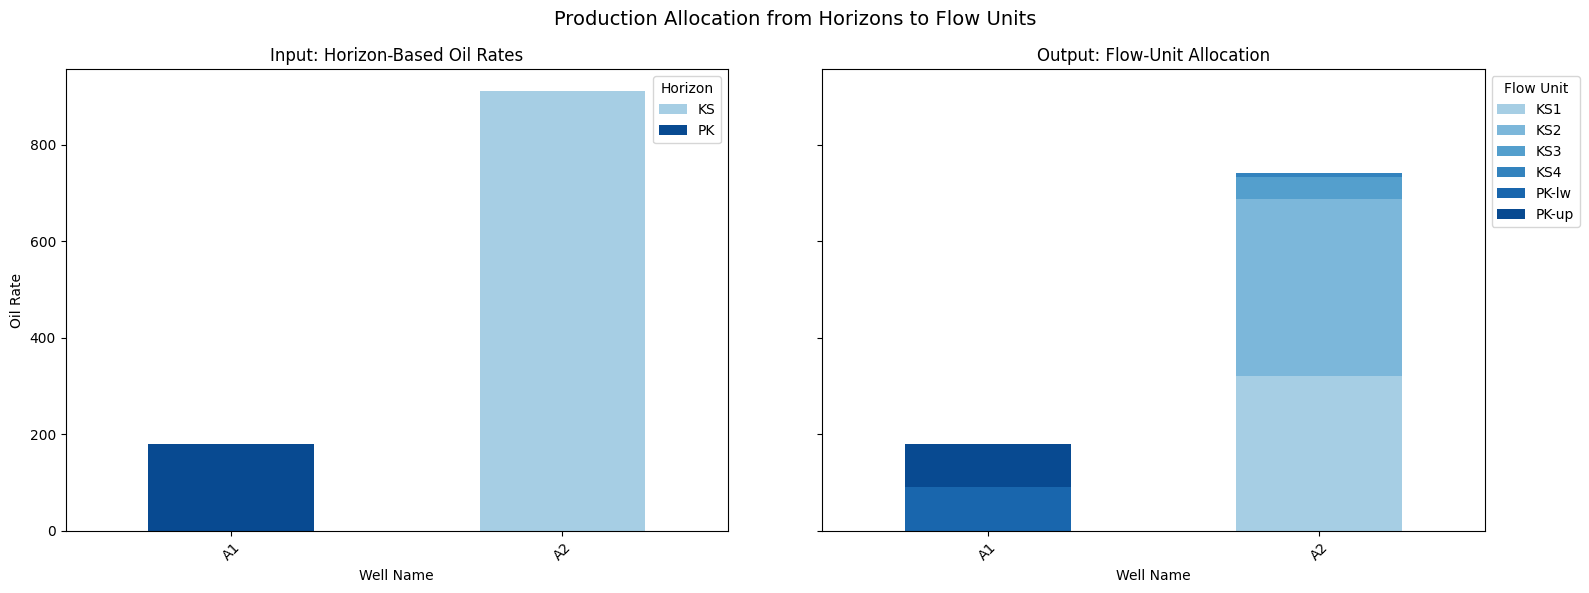

,WellName,Date,FlowUnit
29,A2,2022-03-01,KS
30,A2,2022-04-01,KS


In [9]:
import matplotlib.pyplot as plt


def plot_allocation_overview(rates_df, allocation_df):
    """Visualize how horizon-based production is redistributed to flow units."""
    well_order = sorted(rates_df['WellName'].unique())

    input_summary = (
        rates_df.groupby(['WellName', 'Horizon'], as_index=False)['OilRate']
        .sum()
        .pivot(index='WellName', columns='Horizon', values='OilRate')
        .reindex(well_order)
        .fillna(0)
    )

    numeric_allocation = allocation_df.copy()
    numeric_allocation['OilRate'] = pd.to_numeric(numeric_allocation['OilRate'], errors='coerce')
    numeric_allocation = numeric_allocation.dropna(subset=['OilRate'])
    output_summary = (
        numeric_allocation.groupby(['WellName', 'FlowUnit'], as_index=False)['OilRate']
        .sum()
        .pivot(index='WellName', columns='FlowUnit', values='OilRate')
        .reindex(well_order)
        .fillna(0)
    )

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    if input_summary.shape[1]:
        input_colors = plt.cm.Blues(np.linspace(0.35, 0.9, input_summary.shape[1]))
        input_summary.plot(kind='bar', stacked=True, ax=axes[0], color=input_colors)
    else:
        axes[0].text(0.5, 0.5, 'No horizon-based rates to display', ha='center', va='center')

    axes[0].set_title('Input: Horizon-Based Oil Rates')
    axes[0].set_xlabel('Well Name')
    axes[0].set_ylabel('Oil Rate')
    axes[0].legend(title='Horizon', bbox_to_anchor=(1, 1))

    if output_summary.shape[1]:
        output_colors = plt.cm.Blues(np.linspace(0.35, 0.9, output_summary.shape[1]))
        output_summary.plot(kind='bar', stacked=True, ax=axes[1], color=output_colors)
    else:
        axes[1].text(0.5, 0.5, 'No distributed flow-unit rates to display', ha='center', va='center')

    axes[1].set_title('Output: Flow-Unit Allocation')
    axes[1].set_xlabel('Well Name')
    axes[1].legend(title='Flow Unit', bbox_to_anchor=(1, 1))

    for ax in axes:
        ax.tick_params(axis='x', rotation=45)

    fig.suptitle('Production Allocation from Horizons to Flow Units', fontsize=14)
    plt.tight_layout()
    plt.show()

    shale_warnings = allocation_df[allocation_df['OilRate'] == 'PRODUCTION FROM SHALE WARNING']
    if not shale_warnings.empty:
        display(shale_warnings[['WellName', 'Date', 'FlowUnit']].drop_duplicates())


plot_allocation_overview(rates, allocation_df)